In [84]:
import tensorflow as tf
from tensorflow.keras import models, layers
import matplotlib.pyplot as plt
from IPython.display import HTML

In [85]:
BATCH_SIZE = 32
IMAGE_SIZE = 256
CHANNELS=3
EPOCHS=50

In [86]:
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    "/content/drive/MyDrive/Dataset1",
    seed=123,
    shuffle=True,
    image_size=(IMAGE_SIZE,IMAGE_SIZE),
    batch_size=BATCH_SIZE
)

Found 399 files belonging to 3 classes.


In [87]:
class_names = dataset.class_names
class_names

['ATALA', 'BROWN SIPROETA', 'INDRA SWALLOW']

In [88]:
for image_batch, labels_batch in dataset.take(1):
    print(image_batch.shape)
    print(labels_batch.numpy())

(32, 256, 256, 3)
[1 0 2 2 2 2 1 1 1 2 0 1 0 0 1 0 1 2 0 1 2 0 1 0 1 2 1 0 1 1 0 2]


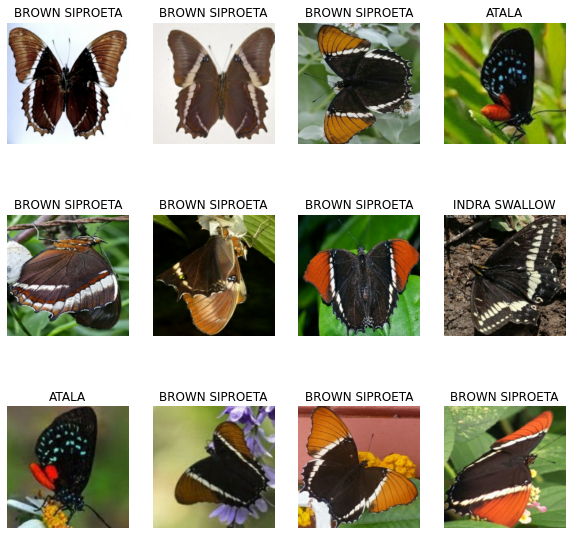

In [89]:
plt.figure(figsize=(10, 10))
for image_batch, labels_batch in dataset.take(1):
    for i in range(12):
        ax = plt.subplot(3, 4, i + 1)
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        plt.title(class_names[labels_batch[i]])
        plt.axis("off")

In [90]:
len(dataset)

13

In [91]:
train_size = 0.8
len(dataset)*train_size

10.4

In [92]:
train_ds = dataset.take(54)
len(train_ds)

13

In [93]:
test_ds = dataset.skip(54)
len(test_ds)

0

In [94]:
val_size=0.1
len(dataset)*val_size

1.3

In [95]:
val_ds = test_ds.take(6)
len(val_ds)

0

In [96]:
test_ds = test_ds.skip(6)
len(test_ds)

0

In [97]:
def get_dataset_partitions_tf(ds, train_split=0.8, val_split=0.1, test_split=0.1, shuffle=True, shuffle_size=10000):
    assert (train_split + test_split + val_split) == 1
    
    ds_size = len(ds)
    
    if shuffle:
        ds = ds.shuffle(shuffle_size, seed=12)
    
    train_size = int(train_split * ds_size)
    val_size = int(val_split * ds_size)
    
    train_ds = ds.take(train_size)    
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)
    
    return train_ds, val_ds, test_ds

In [98]:
train_ds, val_ds, test_ds = get_dataset_partitions_tf(dataset)

In [99]:
len(train_ds)

10

In [100]:
len(val_ds)

1

In [101]:
len(test_ds)

2

In [102]:
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

In [103]:
resize_and_rescale = tf.keras.Sequential([
  layers.experimental.preprocessing.Resizing(IMAGE_SIZE, IMAGE_SIZE),
  layers.experimental.preprocessing.Rescaling(1./255),
])

In [104]:
data_augmentation = tf.keras.Sequential([
  layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
  layers.experimental.preprocessing.RandomRotation(0.2),
])

In [105]:
train_ds = train_ds.map(
    lambda x, y: (data_augmentation(x, training=True), y)
).prefetch(buffer_size=tf.data.AUTOTUNE)


In [106]:
input_shape = (BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE, CHANNELS)
n_classes = 3

model = models.Sequential([
    resize_and_rescale,
    layers.Conv2D(32, kernel_size = (3,3), activation='relu', input_shape=input_shape),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(n_classes, activation='softmax'),
])

model.build(input_shape=input_shape)

In [107]:
model.summary()

Model: "sequential_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_9 (Sequential)   (32, 256, 256, 3)         0         
                                                                 
 conv2d_18 (Conv2D)          (32, 254, 254, 32)        896       
                                                                 
 max_pooling2d_18 (MaxPoolin  (32, 127, 127, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_19 (Conv2D)          (32, 125, 125, 64)        18496     
                                                                 
 max_pooling2d_19 (MaxPoolin  (32, 62, 62, 64)         0         
 g2D)                                                            
                                                                 
 conv2d_20 (Conv2D)          (32, 60, 60, 64)        

In [108]:
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

In [109]:
history = model.fit(
    train_ds,
    batch_size=BATCH_SIZE,
    validation_data=val_ds,
    verbose=1,
    epochs=50,
)

Epoch 1/50
10/10 [==============================] - 69s 4s/step - loss: 1.1197 - accuracy: 0.3168 - val_loss: 1.1011 - val_accuracy: 0.3125
Epoch 2/50
10/10 [==============================] - 35s 3s/step - loss: 1.0934 - accuracy: 0.3894 - val_loss: 1.0967 - val_accuracy: 0.3125
Epoch 3/50
10/10 [==============================] - 35s 3s/step - loss: 1.0491 - accuracy: 0.5149 - val_loss: 0.9474 - val_accuracy: 0.5625
Epoch 4/50
10/10 [==============================] - 37s 4s/step - loss: 0.8744 - accuracy: 0.6040 - val_loss: 0.7932 - val_accuracy: 0.5625
Epoch 5/50
10/10 [==============================] - 35s 3s/step - loss: 0.8812 - accuracy: 0.6139 - val_loss: 0.8232 - val_accuracy: 0.6562
Epoch 6/50
10/10 [==============================] - 35s 3s/step - loss: 0.8068 - accuracy: 0.6469 - val_loss: 0.7673 - val_accuracy: 0.6562
Epoch 7/50
10/10 [==============================] - 35s 3s/step - loss: 0.7590 - accuracy: 0.6601 - val_loss: 0.8050 - val_accuracy: 0.5625
Epoch 8/50
10/10 [==

In [110]:
scores = model.evaluate(test_ds)

2/2 [==============================] - 3s 862ms/step - loss: 0.0490 - accuracy: 0.9688


In [111]:
scores

[0.049016281962394714, 0.96875]

In [112]:
history

In [113]:
history.params

{'verbose': 1, 'epochs': 50, 'steps': 10}

In [114]:
history.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

In [115]:
type(history.history['loss'])

list

In [116]:
len(history.history['loss'])

50

In [117]:
history.history['loss'][:5] # show loss for first 5 epochs

[1.1197483539581299,
 1.0933589935302734,
 1.0490906238555908,
 0.8744170665740967,
 0.8812142014503479]

In [118]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

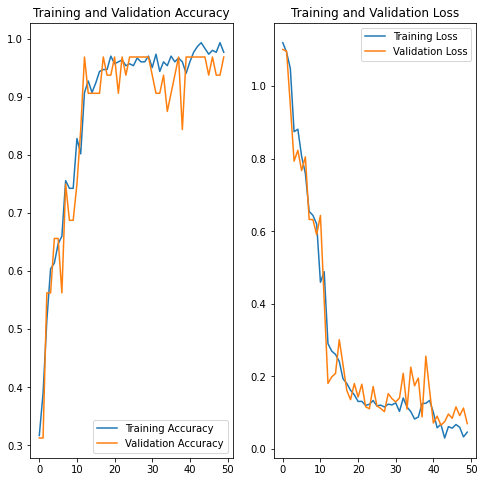

In [119]:
plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(range(EPOCHS), acc, label='Training Accuracy')
plt.plot(range(EPOCHS), val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(range(EPOCHS), loss, label='Training Loss')
plt.plot(range(EPOCHS), val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

first image to predict
actual label: BROWN SIPROETA
1/1 [==============================] - 1s 1s/step
predicted label: BROWN SIPROETA


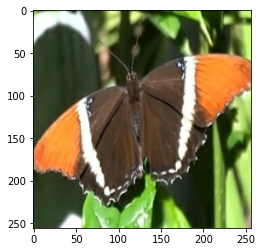

In [120]:
import numpy as np
for images_batch, labels_batch in test_ds.take(1):
    
    first_image = images_batch[27].numpy().astype('uint8')
    first_label = labels_batch[27].numpy()
    
    print("first image to predict")
    plt.imshow(first_image)
    print("actual label:",class_names[first_label])
    
    batch_prediction = model.predict(images_batch)
    print("predicted label:",class_names[np.argmax(batch_prediction[0])])

In [121]:
def predict(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array = tf.expand_dims(img_array, 0)

    predictions = model.predict(img_array)

    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100 * (np.max(predictions[0])), 2)
    return predicted_class, confidence

1/1 [==============================] - 0s 60ms/step


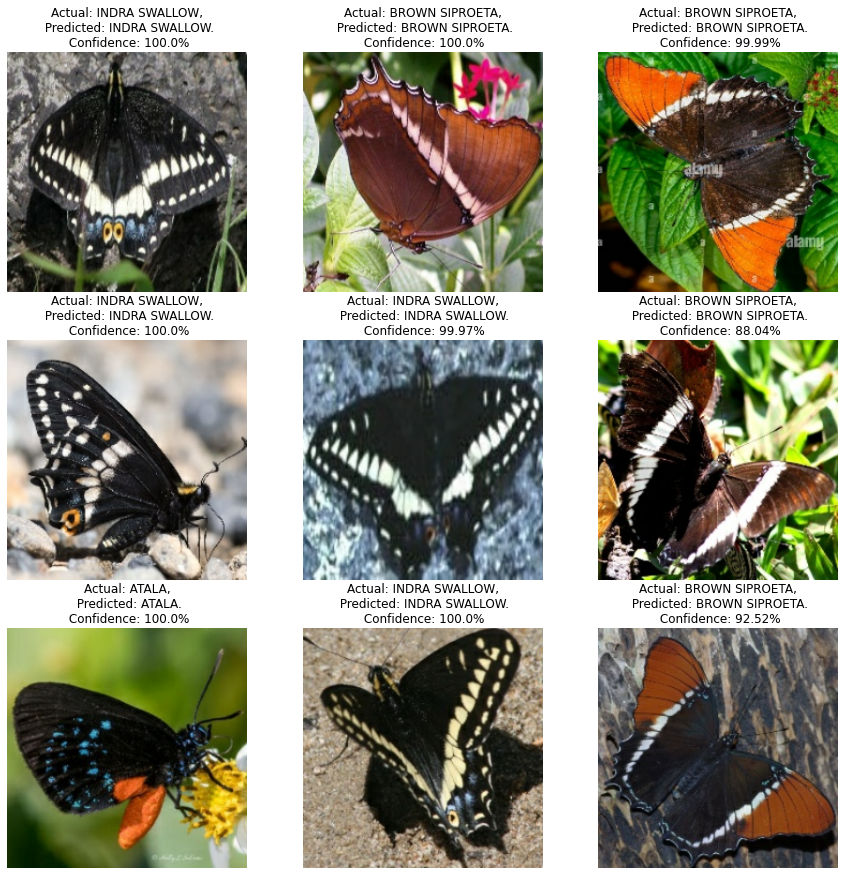

In [122]:
plt.figure(figsize=(15, 15))
for images, labels in test_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        
        predicted_class, confidence = predict(model, images[i].numpy())
        actual_class = class_names[labels[i]] 
        
        plt.title(f"Actual: {actual_class},\n Predicted: {predicted_class}.\n Confidence: {confidence}%")
        
        plt.axis("off")

In [123]:
model.save('./models', save_format='tf')

In [124]:
!pip install gradio

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 11.6 MB 7.6 MB/s 
     |████████████████████████████████| 106 kB 59.8 MB/s 
     |████████████████████████████████| 84 kB 3.0 MB/s 
     |████████████████████████████████| 2.3 MB 53.3 MB/s 
     |████████████████████████████████| 54 kB 2.8 MB/s 
     |████████████████████████████████| 56 kB 4.3 MB/s 
     |████████████████████████████████| 278 kB 64.0 MB/s 
     |████████████████████████████████| 55 kB 2.8 MB/s 
     |████████████████████████████████| 84 kB 3.1 MB/s 
     |████████████████████████████████| 213 kB 48.3 MB/s 
     |████████████████████████████████| 64 kB 2.2 MB/s 
     |████████████████████████████████| 80 kB 7.9 MB/s 
     |████████████████████████████████| 68 kB 5.6 MB/s 
     |████████████████████████████████| 68 kB 5.8 MB/s 
     |████████████████████████████████| 68 kB 5.8 MB/s 
     |████████████████████████████████| 46 kB 3.3 M

In [125]:
import gradio as gr

In [130]:
def predict_image(img):
  img_4d=img.reshape(-1,256,256,3)
  prediction=model.predict(img_4d)[0]
  return {class_names[i]: float(prediction[i]) for i in range(3)}

In [131]:
image = gr.inputs.Image(shape=(256,256))
label = gr.outputs.Label(num_top_classes=3)

gr.Interface(fn=predict_image, inputs=image, outputs=label,interpretation='default').launch(debug='True')

/usr/local/lib/python3.7/dist-packages/gradio/inputs.py:257: UserWarning: Usage of gradio.inputs is deprecated, and will not be supported in the future, please import your component from gradio.components
  "Usage of gradio.inputs is deprecated, and will not be supported in the future, please import your component from gradio.components",
/usr/local/lib/python3.7/dist-packages/gradio/deprecation.py:40: UserWarning: `optional` parameter is deprecated, and it has no effect
  warnings.warn(value)
/usr/local/lib/python3.7/dist-packages/gradio/outputs.py:197: UserWarning: Usage of gradio.outputs is deprecated, and will not be supported in the future, please import your components from gradio.components
  "Usage of gradio.outputs is deprecated, and will not be supported in the future, please import your components from gradio.components",
/usr/local/lib/python3.7/dist-packages/gradio/deprecation.py:40: UserWarning: The 'type' parameter has been deprecated. Use the Number component instead.
 

Colab notebook detected. This cell will run indefinitely so that you can see errors and logs. To turn off, set debug=False in launch().
Note: opening Chrome Inspector may crash demo inside Colab notebooks.

To create a public link, set `share=True` in `launch()`.


<IPython.core.display.Javascript object>

1/1 [==============================] - 0s 53ms/step
Keyboard interruption in main thread... closing server.
